In [1]:
import os
import os.path as pth
import json
import shutil
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
BASE_MODEL_NAME = 'InceptionV3-for-upload'
my_model_base = keras.applications.inception_v3
my_model = my_model_base.InceptionV3

config = {
    'is_zscore':True,
    
    # 'input_shape': (540, 960, 3),
    'aug': {
        'resize': (270, 480),
        #'resize': (297, 528),
    },
    # 'input_shape': (224, 360, 3),
    #'input_shape': (270, 480, 3),
    'input_shape': (270, 480, 3),

    'output_activation': 'softmax',
    'num_class': 1049,
    'output_size': 1049,
    
    'conv':{
        'conv_num': (0), # (3,5,3),
        'base_channel': 0, # 4,
        'kernel_size': 0, # 3,
        'padding':'same',
        'stride':'X'
    },
    'pool':{
        'type':'X',
        'size':'X',
        'stride':'X',
        'padding':'same'
    },
    'fc':{
        'fc_num': 0,
     },
    
    'activation':'relu',
    
    'between_type': 'avg',
    
    'is_batchnorm': True,
    'is_dropout': False,
    'dropout_rate': 0.5,
    
    'add_dense':True,
    'dense_size': 1024,
    
    'batch_size': 64, #64,
    'buffer_size': 256, #256,
    'loss': 'CategoricalCrossentropy',
    
    'num_epoch': 10000,
    'learning_rate': 1e-5, #1e-3,
    
    'random_state': 7777
}

In [4]:
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['randmark_id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def resize_and_crop_func(image, label):
    result_image = tf.image.resize(image, config['aug']['resize'])
    #result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)
    return result_image, label

def image_aug_func(image, label):
    pass
    return image, label

def post_process_func(image, label):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    onehot_label = tf.one_hot(label, depth=config['num_class'])
    return result_image, onehot_label

In [5]:
data_base_path = pth.join('data', 'public')  
os.makedirs(data_base_path, exist_ok=True)

In [6]:
category_csv_name = 'category.csv'
category_json_name = 'category.json'
submission_csv_name = 'sample_submisstion.csv'
train_csv_name = 'train.csv'

# train_zip_name = 'train.zip'
train_tfrecord_name = 'all_train.tfrecords'
train_tfrecord_path = pth.join(data_base_path, train_tfrecord_name)
val_tfrecord_name = 'all_val.tfrecords'
val_tfrecord_path = pth.join(data_base_path, val_tfrecord_name)
# test_zip_name = 'test.zip'
test_tfrecord_name = 'test.tfrecords'
test_tfrecord_path = pth.join(data_base_path, test_tfrecord_name)

In [7]:
train_csv_path = pth.join(data_base_path, train_csv_name)
train_df = pd.read_csv(train_csv_path)
train_dict = {k:v for k, v in train_df.values}

submission_csv_path = pth.join(data_base_path, submission_csv_name)
submission_df = pd.read_csv(submission_csv_path)
# submission_df.head()

category_csv_path = pth.join(data_base_path, category_csv_name)
category_df = pd.read_csv(category_csv_path)
category_dict = {k:v for k, v in category_df.values}
# category_df.head()

In [8]:
train_tfrecord_path

'data/public/all_train.tfrecords'

### Model

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import os
import os.path as pth
import shutil
import time
from tqdm import tqdm

import itertools
from itertools import product, combinations

import numpy as np
from PIL import Image

from IPython.display import clear_output

from multiprocessing import Process, Queue
import datetime

import tensorflow.keras as keras

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv3D, AveragePooling3D, MaxPooling3D, Dropout, \
                                    Concatenate, GlobalMaxPool3D, GlobalAvgPool3D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import max_norm

In [10]:
conv_comb_list = []
conv_comb_list += [(0,)]

base_channel_list = [0]

fc_list = [0] # 128, 0

# between_type_list = [None, 'avg', 'max']
between_type_list = ['avg']

batch_size_list = [80]

activation_list = ['relu']

# len(conv_comb_list), conv_comb_list

In [11]:
def build_cnn(config):
    input_layer = Input(shape=config['input_shape'], name='input_layer')
    pret_model = my_model(
        input_tensor=input_layer, include_top=False, weights='imagenet', 
        input_shape=config['input_shape'], pooling=config['between_type'], 
        classes=config['output_size']
    )

    pret_model.trainable = False
    
    x = pret_model.output
    
    if config['between_type'] == None:
        x = Flatten(name='flatten_layer')(x)
        
    if config['is_dropout']:
        x = Dropout(config['dropout_rate'], name='output_dropout')(x)    

    if config['add_dense']:
        x = Dense(config['dense_size'], activation=config['activation'],
                    name='dense_layer')(x)

    x = Dense(config['output_size'], activation=config['output_activation'], 
          name='output_fc')(x)
#     x = Activation(activation=config['output_activation'], name='output_activation')(x)
    model = Model(inputs=input_layer, outputs=x, name='{}'.format(BASE_MODEL_NAME))

    return model

In [12]:
model = build_cnn(config)
for i, layer in enumerate(model.layers):
    print(i, layer.name)
#model.summary(line_length=150)
del model

0 input_layer
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_

In [12]:
origin_train_len = len(train_df) / 5 * 4
origin_val_len = len(train_df) / 5 * 1

train_num_steps = int(np.ceil((origin_train_len)/config['batch_size']))
val_num_steps = int(np.ceil((origin_val_len)/config['batch_size']))

print(train_num_steps, val_num_steps)

1102 276


In [13]:
model_base_path = data_base_path
model_checkpoint_path = pth.join(model_base_path, 'checkpoint')

In [14]:
def get_lr_callback():
    lr_start   = 0.000001*10*0.5
    lr_max     = 0.0000005 * config['batch_size'] * 10*0.5
    lr_min     = 0.000001 * 10*0.5
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
     
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    return lr_callback

InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
Epoch 1/6
882/882 [==============================] - 492s 558ms/step - loss: 3.6642 - acc: 0.3573 - precision: 0.9178 - recall: 0.1679 - auc: 0.8379 - val_loss: 2.0807 - val_acc: 0.5538 - val_precision: 0.8183 - val_recall: 0.3769 - val_auc: 0.9487
Epoch 2/6
882/882 [==============================] - 490s 556ms/step - loss: 1.2117 - acc: 0.7314 - precision: 0.9185 - recall: 0.6157 - auc: 0.9742 - val_loss: 2.5389 - val_acc: 0.4851 - val_precision: 0.5367 - val_recall: 0.4212 - val_auc: 0.9118
Epoch 3/6
882/882 [==============================] - 491s 557ms/step - loss: 0.7573 - acc: 0.8219 - precision: 0.9290 - recall: 0.7607 - auc: 0.9842 - val_loss: 0.9168 - val_acc: 0.7925 - val_precision: 0.8960 - val_recall: 0.7401 - val_auc: 0.9765
Epoch 4/6
882/882 [==============================] - 491s 557ms/step - loss: 0.5486 - acc: 0.8668 - precision: 0.9359 - recall: 0.8249 - auc: 0.989

882/882 [==============================] - 620s 703ms/step - loss: 0.3354 - acc: 0.9129 - precision: 0.9480 - recall: 0.8952 - auc: 0.9932 - val_loss: 0.4411 - val_acc: 0.8992 - val_precision: 0.9345 - val_recall: 0.8845 - val_auc: 0.9887
Epoch 8/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9879 - precision: 0.9917 - recall: 0.9843 - auc: 0.9996
Epoch 00008: val_loss improved from 0.44113 to 0.31178, saving model to data/public/checkpoint/InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000008-0.311777-0.046330.hdf5
882/882 [==============================] - 618s 701ms/step - loss: 0.0463 - acc: 0.9879 - precision: 0.9917 - recall: 0.9843 - auc: 0.9996 - val_loss: 0.3118 - val_acc: 0.9349 - val_precision: 0.9542 - val_recall: 0.9280 - val_auc: 0.9905
Epoch 9/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9977 - precision: 0.9980 - recall: 0.9971 - auc: 1.0000
E

Epoch 25/10000
881/882 [============================>.] - ETA: 0s - loss: 2.8123e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 00025: val_loss did not improve from 0.27545
882/882 [==============================] - 617s 699ms/step - loss: 4.0446e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.2859 - val_acc: 0.9485 - val_precision: 0.9614 - val_recall: 0.9436 - val_auc: 0.9906
Epoch 26/10000
881/882 [============================>.] - ETA: 0s - loss: 2.7726e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 00026: val_loss did not improve from 0.27545
882/882 [==============================] - 618s 700ms/step - loss: 3.5110e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.2842 - val_acc: 0.9486 - val_precision: 0.9613 - val_recall: 0.9438 - val_auc: 0.9905
Epoch 00026: early stopping



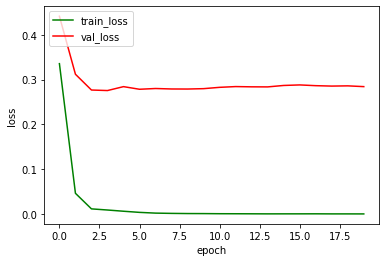

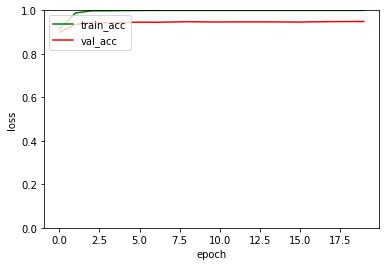

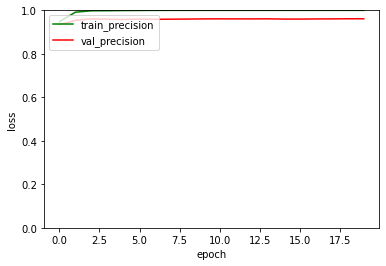

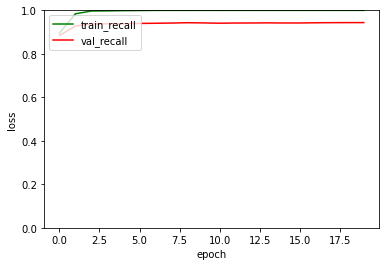

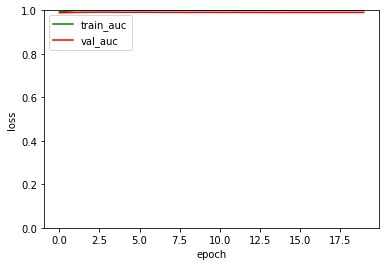

In [16]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # dataset = dataset.cache()
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(config['buffer_size'])
    dataset = dataset.batch(config['batch_size'])
    dataset = dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.TFRecordDataset(val_tfrecord_path, compression_type='GZIP')
    val_dataset = val_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.shuffle(config['buffer_size'])
    val_dataset = val_dataset.batch(config['batch_size'])
    val_dataset = val_dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.cache()
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    
    initial_epoch = 0

    if pth.isdir(model_path) and len([_ for _ in os.listdir(model_path) if _.endswith('hdf5')]) >= 1:
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
        
        model_chk_name = sorted(os.listdir(model_path))[-1]
        initial_epoch = int(model_chk_name.split('-')[0])
        model.load_weights(pth.join(model_path, model_chk_name))
    else:
        # first: train only the top layers (which were randomly initialized)
        # i.e. freeze all convolutional InceptionV3 layers
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                     metrics=['acc', 'Precision', 'Recall', 'AUC'])
        
        PRE_TRAIN_EPOCH = 6
        model.fit(
            x=dataset, epochs=PRE_TRAIN_EPOCH, # train only top layers for just a few epochs.
            validation_data=val_dataset, shuffle=True,
            #callbacks = [checkpointer, es], #batch_size=config['batch_size']
            initial_epoch=initial_epoch,
            # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
            verbose=1)
        
        # at this point, the top layers are well trained and we can start fine-tuning
        # convolutional layers from inception V3. We will freeze the bottom N layers
        # and train the remaining top layers.
        
        # let's visualize layer names and layer indices to see how many layers
        # we should freeze:
        for i, layer in enumerate(model.layers):
           print(i, layer.name)
        
        # we chose to train the top 2 inception blocks, i.e. we will freeze
        # the first 249 layers and unfreeze the rest:
        for layer in model.layers[:229]:  # [:249]:
           layer.trainable = False
        for layer in model.layers[229:]:  # [249:]:
           layer.trainable = True
        
        # we need to recompile the model for these modifications to take effect
        # we use Adam with a low learning rate
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
            metrics=['acc', 'Precision', 'Recall', 'AUC'])
        
        initial_epoch = PRE_TRAIN_EPOCH

        
    # IGNORE 4 lines below in InceptionV3 
    # ### Freeze first layer
    # conv_list = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)]
    # conv_list[0].trainable = False
    # # conv_list[1].trainable = False

    os.makedirs(model_path, exist_ok=True)
    model_filename = pth.join(model_path, '{epoch:06d}-{val_loss:0.6f}-{loss:0.6f}.hdf5')
    checkpointer = ModelCheckpoint(
        filepath=model_filename, verbose=1, 
        period=1, save_best_only=True, 
        monitor='val_loss'
    )
    es = EarlyStopping(monitor='val_loss', verbose=1, patience=16)  ### 16 at night. 10 genral, 6 for experiment

    hist = model.fit(
        x=dataset, epochs=config['num_epoch'], 
        validation_data=val_dataset, shuffle=True,
        callbacks = [get_lr_callback(), checkpointer, es], #batch_size=config['batch_size']
        initial_epoch=initial_epoch,
        # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
        verbose=1
    )

    model_analysis_path = model_path.replace('checkpoint', 'analysis')
    visualization_path = pth.join(model_analysis_path,'visualization')
    os.makedirs(visualization_path, exist_ok=True)
    
    print()
    # clear_output()        
    for each_label in ['loss', 'acc', 'precision', 'recall', 'auc']:
        fig, ax = plt.subplots()
        ax.plot(hist.history[each_label], 'g', label='train_{}'.format(each_label))
        ax.plot(hist.history['val_{}'.format(each_label)], 'r', label='val_{}'.format(each_label))
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        if not each_label == 'loss':
            plt.ylim(0, 1)
        plt.show()
        filename = 'learning_curve_{}'.format(each_label)
#             fig.savefig(pth.join(visualization_path, filename), transparent=True)
        plt.cla()
        plt.clf()
        plt.close('all')

    np.savez_compressed(pth.join(visualization_path, 'learning_curve'), 
                        loss=hist.history['loss'], 
                        val_loss=hist.history['val_loss'],
                        acc=hist.history['acc'], 
                        val_acc=hist.history['val_acc'],
                        precision=hist.history['precision'], 
                        vaval_precisionl_mae=hist.history['val_precision'],  
                        recall=hist.history['recall'],
                        val_recall=hist.history['val_recall'],
                        auc=hist.history['auc'],
                        val_auc=hist.history['val_auc']
                        )

    model.save(pth.join(model_path, '000000_last.hdf5'))
    K.clear_session()
    del(model)
    
    model_analysis_base_path = pth.join(model_base_path, 'analysis', model_name) 
    with open(pth.join(model_analysis_base_path, 'config.json'), 'w') as f:
        json.dump(config, f)

    chk_name_list = sorted([name for name in os.listdir(model_path) if name != '000000_last.hdf5'])
    for chk_name in chk_name_list[:-2]:
        os.remove(pth.join(model_path, chk_name))
    # clear_output()

### Inference

In [15]:
image_feature_description_for_test = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    # 'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_for_test(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description_for_test)

def map_func_for_test(target_record):
    img = target_record['image_raw']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img

def resize_and_crop_func_for_test(image):
    result_image = tf.image.resize(image, config['aug']['resize'])
    #result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)
    return result_image

def post_process_func_for_test(image):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    return result_image

In [16]:
submission_base_path = pth.join(data_base_path, 'submission')
os.makedirs(submission_base_path, exist_ok=True)

In [17]:
preds = []
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
    test_dataset = test_dataset.map(_parse_image_function_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(map_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(resize_and_crop_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(config['batch_size'])
    test_dataset = test_dataset.map(post_process_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    model_chk_name = sorted(os.listdir(model_path))[-1]
    initial_epoch = int(model_chk_name.split('-')[0])
    model.load_weights(pth.join(model_path, model_chk_name))

    preds = model.predict(test_dataset, verbose=1)
    
    #pred_labels = np.argmax(preds, axis=1)
    #pred_probs = np.array([pred[indice] for pred, indice in zip(preds, pred_labels)])
    
    # argmax --> top3
    pred_labels = np.argsort(-preds)
    
    submission_csv_path = pth.join(data_base_path, submission_csv_name)
    submission_df = pd.read_csv(submission_csv_path)
    
    merged_df = []
    
    RANK_TO_SAVE = 5
    for i in range(RANK_TO_SAVE):
        tmp_df = submission_df.copy()
        
        tmp_labels = pred_labels[:, i]
        tmp_df['landmark_id'] = tmp_labels
        tmp_df['conf'] = np.array([pred[indice] for pred, indice in zip(preds, tmp_labels)])
        merged_df.append(tmp_df)
    
    submission_df = pd.concat(merged_df)
    
    #submission_df['landmark_id'] = pred_labels
    #submission_df['conf'] = pred_probs

    today_str = datetime.date.today().strftime('%Y%m%d')
    result_filename = '{}.csv'.format(model_name)
    submission_csv_fileaname = pth.join(submission_base_path, '_'.join([today_str, result_filename]))
    submission_df.to_csv(submission_csv_fileaname, index=False)

InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
      1/Unknown - 0s 49us/stepWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_predict_batch_end` time: 0.3532s). Check your callbacks.
475/475 [==============================] - 186s 393ms/step
